# Curso Estatística Básico ao Avançado (EBA)
*Renata Biaggi*

Neste notebook, sigo os passos para desenhar um Teste A/B entre dois sites e tava de conversão.

## Imports

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

# Scientific/ Stats
import scipy.stats as scs
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

## Load Data

In [2]:
# Load data
df = pd.read_csv('/content/AB_dataset.csv')
df

,id,variante,compra,data
0,0x6f9421,A,False,2019-12-26
1,0x59d442,A,False,2019-08-16
2,0x6db8f8,A,True,2019-03-18
3,0x68245d,A,False,2019-02-13
4,0x28566e,A,False,2019-09-28
...,...,...,...,...
54995,0x451451,A,False,2019-06-19
54996,0x871d51,A,False,2019-03-22
54997,0x50d163,A,False,2019-02-10
54998,0x3544c4,B,False,2020-01-09


In [4]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        55000 non-null  object
 1   variante  55000 non-null  object
 2   compra    55000 non-null  bool  
 3   data      55000 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


## Test Design

A variável de métrica será `compra`, que quando transformado em proporção será a taxa de conversão. <br>
* A amosta `A` é o controle.
* A amostra `B` é o teste.

* **Ho : Pa = Pb**
* **Ha : Pa ≠ Pb**
* Poder Estatístico do Teste : 80%
* Nível de Confiança: 95%
* Efeito a ser testado: B 20% a mais do que A


In [11]:
# Separando A e B
df_A = df.query('variante == "A"')
df_B = df.query('variante == "B"')

# Checando conversão de A e B
conversao_A = df_A.compra.sum() / len(df_A)
conversao_B = df_B.compra.sum() / len(df_B)

print(f'Conversão de A: {conversao_A}')
print(f'Conversão de B: {conversao_B}')
print(f'A meta de 20% a mais de conversão é de {conversao_A * 1.2}')

Conversão de A: 0.15206
Conversão de B: 0.1962
A meta de 20% a mais de conversão é de 0.182472


Houve melhora na conversão com a variante B em relação à A.<br>
**B** converteu 4.41% a mais, o que dá uma diferença de 29% da proporção de B em comparação com A.

## Calculando o tamando da amostra.
Para termos um poder estatístico de 80%, precisamos calcular o tamanho da amostra necessária. Para tal, podemos usar o G-Power, software estatístico gratuito disponível [no site da Universidade de Düsseldorf](https://www.psychologie.hhu.de/arbeitsgruppen/allgemeine-psychologie-und-arbeitspsychologie/gpower).

Para teste de duas proporções, basta configurar:
* Test Family: Z_tests
* Sattistical Test: Proportions: Difference between two independent proportions
* Type of Power Aanlysis: A priori...<br>
Segue a imagem

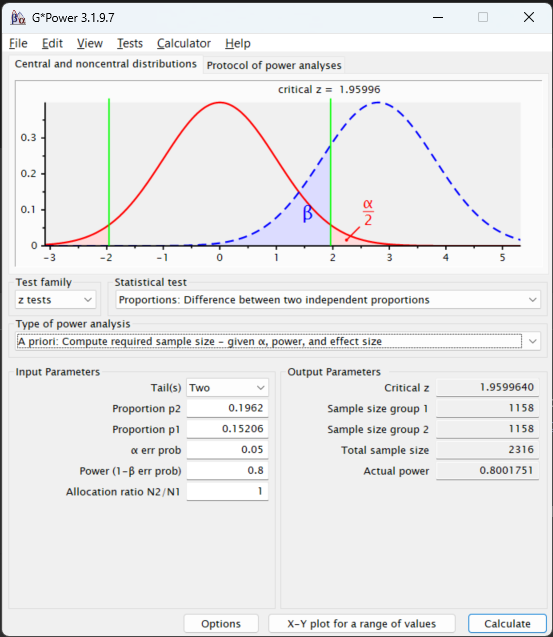

## Teste A/B
Segundo o G-Power, precisamos de 1158 observações de cada amostra. <br>
Vamos coletá-las e depois comparar as duas proporções.

In [34]:
# Sample A
df_A_sample = df_A.sample(1160)

# Sample B
df_B_sample = df_B.sample(1160)

In [36]:
# Get successes for both groups
success_A = df_A_sample.compra.sum()
success_B = df_B_sample.compra.sum()

successes = [success_A, success_B]

# Get the number of observations in each group
n_control = len(df_A_sample)
n_treatment = len(df_B_sample)
nobs = [n_control, n_treatment]

# Test
z_stat, pval = proportions_ztest(successes, nobs=nobs)
print(f'p-value: {pval:.3f}')


p-value: 0.004


Considerando nosso nível de significância de 5%, podemos rejeitar a hitótese nula em favor da alternativa, demonstrando que as proporções de ambos os grupos são diferentes.

In [38]:
# Calculating the Confidence Interval
(lower_A, lower_B), (upper_A, upper_B) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'95% Confidence Interval for A: [{lower_A:.3f}, {upper_A:.3f}]')
print(f'95% Confidence Interval for B: [{lower_B:.3f}, {upper_B:.3f}]')

95% Confidence Interval for A: [0.136, 0.178]
95% Confidence Interval for B: [0.179, 0.226]


Queremos a visualização desses intervalos de confiança.
Podemos usar uma distribuição normal para simular 10 mil testes entre ambas as amostras.

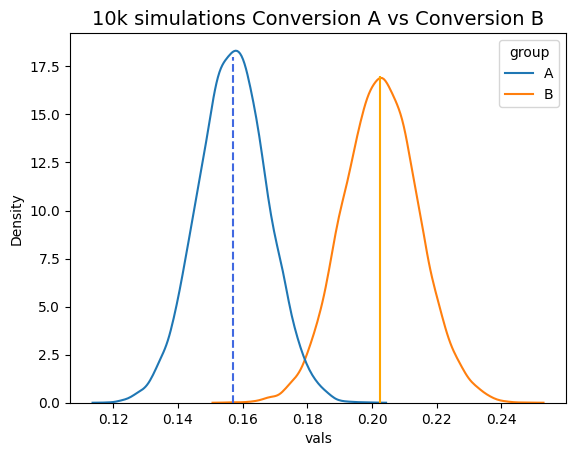

In [75]:
# Compute mean and standard deviation of A
meanA = (lower_A + upper_A) / 2
margin_of_errorA = (upper_A - lower_A) / 2
std_devA = margin_of_errorA / 1.96 # 95% CI

# Compute mean and standard deviation of B
meanB = (lower_B + upper_B) / 2
margin_of_errorB = (upper_B - lower_B) / 2
std_devB = margin_of_errorB / 1.96  # 95% CI


# Tests
N= 10_000

# Plot data
plot = pd.DataFrame({'group': np.repeat(['A', 'B'], N),
                     'vals': np.concatenate([np.random.normal(loc=meanA,
                                                              scale=std_devA,
                                                              size=N),
                                             np.random.normal(loc=meanB,
                                                              scale=std_devB,
                                                              size=N) ])
                     })


# Plot
sns.kdeplot(data=plot, x='vals', hue='group')
plt.vlines(x=df_A_sample.compra.mean(), ymin=0, ymax=18, colors='royalblue', linestyles='--')
plt.vlines(x=df_B_sample.compra.mean(), ymin=0, ymax=17, colors='orange')
plt.title("10k simulations Conversion A vs Conversion B", size=14);

Usando todo o dataset.

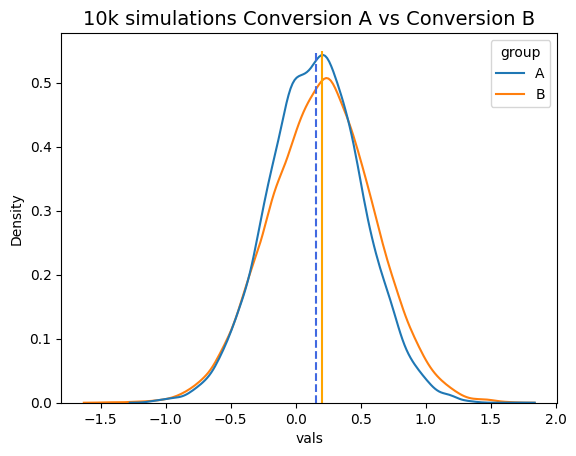

In [77]:
# Tests
N= 10_000

# Plot data
plot = pd.DataFrame({'group': np.repeat(['A', 'B'], N),
                     'vals': np.concatenate([np.random.normal(loc=df.query('variante=="A"').compra.mean(),
                                                              scale=df.query('variante=="A"').compra.std(),
                                                              size=N),
                                             np.random.normal(loc=df.query('variante=="B"').compra.mean(),
                                                              scale=df.query('variante=="B"').compra.std(),
                                                              size=N) ])
                     })
# Plot
sns.kdeplot(data=plot, x='vals', hue='group')
plt.vlines(x=df_A_sample.compra.mean(), ymin=0, ymax=0.55, colors='royalblue', linestyles='--')
plt.vlines(x=df_B_sample.compra.mean(), ymin=0, ymax=0.55, colors='orange')
plt.title("10k simulations Conversion A vs Conversion B", size=14);